# Dataset Loading

In [ ]:
import re
import nltk
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, DistilBertTokenizer, DistilBertForSequenceClassification, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, get_linear_schedule_with_warmup

import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

# Replace the path with the correct file path
ds = pd.read_csv('/content/gdrive/MyDrive/German_mbti_utf8.csv')


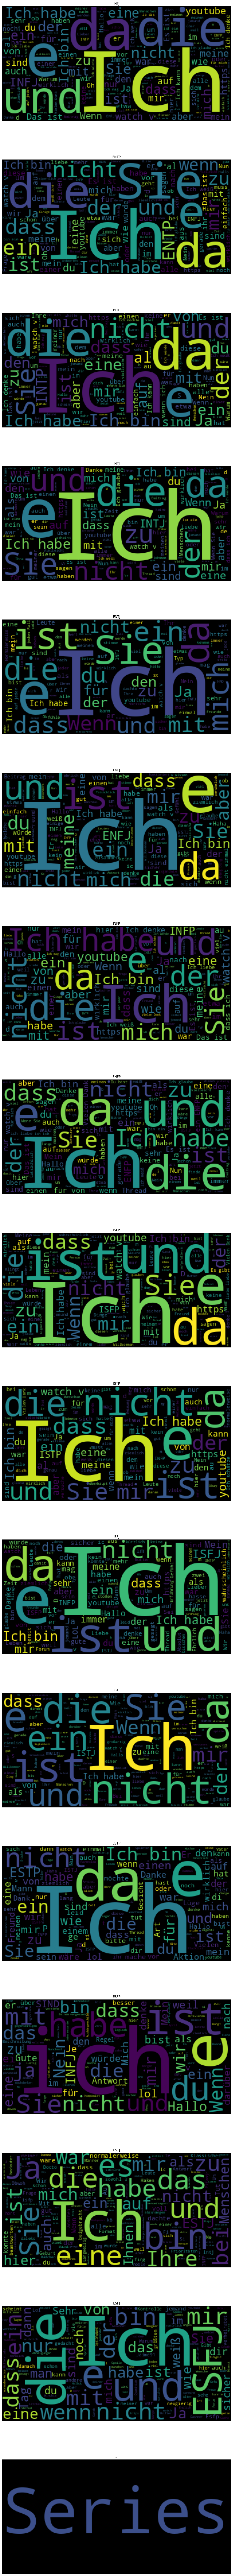

In [ ]:
import imageio
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(len(ds['type'].unique()), sharex=True, figsize=(15,10*len(ds['type'].unique())))

k = 0
for i in ds['type'].unique():
    df_4 = ds[ds['type'] == i]
    wordcloud = WordCloud().generate(df_4['german_posts'].to_string())
    ax[k].imshow(wordcloud)
    ax[k].set_title(i)
    ax[k].axis("off")
    k+=1

In [ ]:
types = [t.lower() for t in ds["type"].unique()]
for post in ds["clean_posts"]:
    for word in post:
        if word in types:
            post.remove(word)

AttributeError: 'float' object has no attribute 'lower'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


type                                        clean_posts
0     INFJ  moment watch v izlegxm sportscent top ten spie...
1     ENTP  find besorgniserregend beitr gen person merk s...
2     INTP  gut sage wei segen fluch z hlt absolut sicher ...
3     INTJ  lieber gespr ch neulich genossen esoterisch ge...
4     ENTJ  gefeuert weiter dumm missverst ndni ann herung...
...    ...                                                ...
8670  ISFP  katzen irgendeinem grund immer f r fi doma hal...
8671  ENFP  thread bereit irgendwo existiert fall teufel l...
8672  INTP  viel fragen ding mach w rde lila pill nehmen w...
8673  INFP  moment zwiesp ltig kinderwunsch geht ehrlich g...
8674  INFP  lang her seit letzt mal personalitycaf anschei...

[8675 rows x 2 columns]

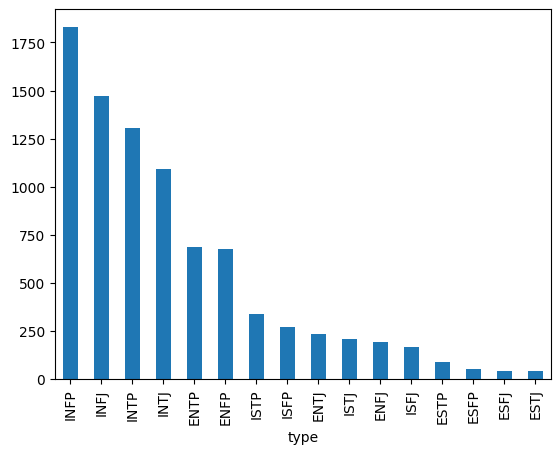

In [ ]:
# Drop rows with NaN values in the 'type' column
ds.dropna(subset=['type'], inplace=True)

# Plot the count of each MBTI type
ds["type"].value_counts().plot(kind="bar")

# Download stopwords
nltk.download("stopwords")

# Convert German posts to lowercase and remove unnecessary characters
ds["clean_posts"] = ds["german_posts"].str.lower()
ds["clean_posts"] = ds["clean_posts"].apply(lambda x: re.sub(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*", "", x)) # Remove links
ds["clean_posts"] = ds["clean_posts"].apply(lambda x: re.sub("\|\|\|", "", x)) # Remove |||
ds["clean_posts"] = ds["clean_posts"].apply(lambda x: re.sub("[0-9]", "", x)) # Remove numbers
ds["clean_posts"] = ds["clean_posts"].apply(lambda x: re.sub("[^a-z]", " ", x)) # Remove punctuation
ds["clean_posts"] = ds["clean_posts"].apply(lambda x: x.split())

# Remove MBTI types from posts
types = [t.lower() for t in ds["type"].unique()]
ds["clean_posts"] = ds["clean_posts"].apply(lambda x: [word for word in x if word not in types])

# Remove stopwords from posts
all_stopwords = stopwords.words("german")
ds["clean_posts"] = ds["clean_posts"].apply(lambda x: [word for word in x if word not in all_stopwords])

# Stemming the words in the posts
ps = PorterStemmer()
ds["clean_posts"] = ds["clean_posts"].apply(lambda x: " ".join([ps.stem(word) for word in x]))

# Drop the original 'german_posts' column
ds.drop(["german_posts"], inplace=True, axis=1)

# Display the cleaned DataFrame
ds.head()
ds

# Define Models and Tokenizer

In [ ]:
# Tokenizers
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

# Models
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=16,  # Number of unique labels
    output_attentions=False,
    output_hidden_states=False
)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=16,
    output_attentions=False,
    output_hidden_states=False
)

distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=16,
    output_attentions=False,
    output_hidden_states=False
)

models = {
    "mBERT": (bert_model, bert_tokenizer),
    "XLM-R": (xlmr_model, xlmr_tokenizer),
    "DistilBERT": (distilbert_model, distilbert_tokenizer)
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define Some Functions

In [ ]:
# Function to preprocess text for BERT
def preprocess_text_bert(text, tokenizer, max_len=128):
    tokenized_text = bert_tokenizer.tokenize(text)
    tokenized_text = ["[CLS]"] + tokenized_text + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    input_ids = input_ids[:max_len] + [tokenizer.pad_token_id] * (max_len - len(input_ids))
    attention_mask = [1] * len(input_ids)
    return torch.tensor(input_ids), torch.tensor(attention_mask)

# Function to preprocess text for DistilBERT
def preprocess_text_distilbert(text, tokenizer, max_len=128):
    inputs = distilbert_tokenizer(
       text,
       padding='max_length',
       truncation=True,
       max_length=max_len,
       return_tensors='pt'
    )
    return inputs.input_ids, inputs.attention_mask

def preprocess_text_xlmr(text, tokenizer, max_len=128):
    inputs = xlmr_tokenizer(
       text,
       padding='max_length',
       truncation=True,
       max_length=max_len,
       return_tensors='pt'
    )
    return inputs.input_ids, inputs.attention_mask


In [ ]:
# Function to train and evaluate a model
def train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, scheduler, device, epochs=3):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch
            model.zero_grad()
            outputs = model(inputs, attention_mask=masks, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Average Training Loss for {model.__class__.__name__}: {avg_train_loss}")

    model.eval()
    preds = []
    true_labels = []
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
        preds.append(logits.detach().cpu().numpy())
        true_labels.append(labels.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return preds, true_labels

In [ ]:
def plot_confusion_matrix(conf_matrix, label_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def calculate_metrics(true_labels, predicted_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    return conf_matrix, class_report, accuracy, f1, precision, recall


In [ ]:
# Function to plot ROC curve and calculate AUC
def plot_roc_curve(true_labels, predicted_probs, label_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(label_names)):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Define Model Dictionary

In [ ]:
# Define labels dictionary
labels_dict = {
    'INFJ': 0, 'ENTP': 1, 'INTP': 2, 'INTJ': 3, 'ENTJ': 4,
    'ENFJ': 5, 'INFP': 6, 'ENFP': 7, 'ISFP': 8, 'ISTP': 9,
    'ISFJ': 10, 'ISTJ': 11, 'ESTP': 12, 'ESFP': 13,
    'ESTJ': 14, 'ESFJ': 15
}

# Model Fine Tuning

In [ ]:
# Define batch size and other parameters
batch_size = 32
max_len = 128
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
input_ids_list = []
attention_mask_list = []

input_ids_list_xlmr = []
attention_mask_list_xlmr = []

input_ids_list_distilbert = []
attention_mask_list_distilbert = []

labels = [labels_dict[label] for label in ds['type'][:100]]
labels = torch.tensor(labels)

for text in ds['clean_posts'][:100]:
    # For mBERT
    input_ids, attention_mask = preprocess_text_bert(text, models['mBERT'][1], max_len)
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)

    # For XLM-R
    input_ids_xlmr, attention_mask_xlmr = preprocess_text_xlmr(text, models['XLM-R'][1], max_len)
    input_ids_list_xlmr.append(input_ids_xlmr)
    attention_mask_list_xlmr.append(attention_mask_xlmr)

    # For DistilBERT
    input_ids_distilbert, attention_mask_distilbert = preprocess_text_distilbert(text, models['DistilBERT'][1], max_len)
    input_ids_list_distilbert.append(input_ids_distilbert)
    attention_mask_list_distilbert.append(attention_mask_distilbert)


input_ids_tensor_bert = torch.stack(input_ids_list)
attention_mask_tensor_bert = torch.stack(attention_mask_list)

input_ids_tensor_xlmr = torch.stack(input_ids_list_xlmr)
attention_mask_tensor_xlmr = torch.stack(attention_mask_list_xlmr)

input_ids_tensor_distilbert = torch.stack(input_ids_list_distilbert)
attention_mask_tensor_distilbert = torch.stack(attention_mask_list_distilbert)


In [ ]:
# For BERT

train_inputs_bert, test_inputs_bert, train_masks_bert, test_masks_bert, train_labels_bert, test_labels_bert = train_test_split(
    input_ids_tensor_bert, attention_mask_tensor_bert, labels, test_size=0.3, random_state=42
)

train_data_bert = TensorDataset(train_inputs_bert, train_masks_bert, train_labels_bert)
train_sampler_bert = RandomSampler(train_data_bert)
train_dataloader_bert = DataLoader(train_data_bert, sampler=train_sampler_bert, batch_size=batch_size)

test_data_bert = TensorDataset(test_inputs_bert, test_masks_bert, test_labels_bert)
test_sampler_bert = SequentialSampler(test_data_bert)
test_dataloader_bert = DataLoader(test_data_bert, sampler=test_sampler_bert, batch_size=batch_size)



# For XLM-R
train_inputs_xlmr, test_inputs_xlmr, train_masks_xlmr, test_masks_xlmr, train_labels_xlmr, test_labels_xlmr = train_test_split(
    input_ids_tensor_xlmr, attention_mask_tensor_xlmr, labels, test_size=0.3, random_state=42
)

train_data_xlmr = TensorDataset(train_inputs_xlmr, train_masks_xlmr, train_labels_xlmr)
train_sampler_xlmr = RandomSampler(train_data_xlmr)
train_dataloader_xlmr = DataLoader(train_data_xlmr, sampler=train_sampler_xlmr, batch_size=batch_size)

test_data_xlmr = TensorDataset(test_inputs_xlmr, test_masks_xlmr, test_labels_xlmr)
test_sampler_xlmr = SequentialSampler(test_data_xlmr)
test_dataloader_xlmr = DataLoader(test_data_xlmr, sampler=test_sampler_xlmr, batch_size=batch_size)

# For DistilBERT
train_inputs_distilbert, test_inputs_distilbert, train_masks_distilbert, test_masks_distilbert, train_labels_distilbert, test_labels_distilbert = train_test_split(
    input_ids_tensor_distilbert, attention_mask_tensor_distilbert, labels, test_size=0.3, random_state=42
)

train_data_distilbert = TensorDataset(train_inputs_distilbert, train_masks_distilbert, train_labels_distilbert)
train_sampler_distilbert = RandomSampler(train_data_distilbert)
train_dataloader_distilbert = DataLoader(train_data_distilbert, sampler=train_sampler_distilbert, batch_size=batch_size)

test_data_distilbert = TensorDataset(test_inputs_distilbert, test_masks_distilbert, test_labels_distilbert)
test_sampler_distilbert = SequentialSampler(test_data_distilbert)
test_dataloader_distilbert = DataLoader(test_data_distilbert, sampler=test_sampler_distilbert, batch_size=batch_size)




# Define a dictionary to store train data loaders for each model
train_dataloaders_dict = {
    "mBERT": train_dataloader_bert,
    "XLM-R": train_dataloader_xlmr,
    "DistilBERT": train_dataloader_distilbert
}


# Define a dictionary to store train data loaders for each model
test_dataloaders_dict = {
    "mBERT": test_dataloader_bert,
    "XLM-R": test_dataloader_xlmr,
    "DistilBERT": test_dataloader_distilbert
}



In [ ]:
results = {}

# Training and evaluation loop for all models
for model_name, (model, tokenizer) in models.items():
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloaders_dict[model_name]) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    print(f"Training {model_name}...")

    # Move model to device
    model.to(device)

    if model_name == 'XLM-R' or model_name == 'DistilBERT' or model_name == 'mBERT':
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for batch in tqdm(train_dataloaders_dict[model_name], desc=f"Epoch {epoch + 1}"):
                batch = tuple(t.to(device) for t in batch)
                inputs, masks, labels = batch

                inputs = inputs.squeeze(1)  # Remove the extra dimension
                masks = masks.squeeze(1)  # Remove the extra dimension

                model.zero_grad()
                outputs = model(inputs, attention_mask=masks, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_dataloaders_dict[model_name])
            print(f"Average Training Loss for {model_name}: {avg_train_loss}")

    # Evaluation loop for BERT
    if model_name == 'mBERT':
        model.eval()
        preds_bert = []
        for batch in tqdm(test_dataloader_bert, desc="Evaluating BERT"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch
            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_bert.append(logits)
        preds_bert = np.concatenate(preds_bert, axis=0)
        results[model_name] = preds_bert

    # Evaluation loop for DistilBERT
    elif model_name == 'DistilBERT':
        model.eval()
        preds_distilbert = []
        for batch in tqdm(test_dataloader_distilbert, desc="Evaluating DistilBERT"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch

            # Ensure correct shape of inputs and masks
            inputs = inputs.squeeze(1)  # Remove the extra dimension
            masks = masks.squeeze(1)  # Remove the extra dimension

            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_distilbert.append(logits)
        preds_distilbert = np.concatenate(preds_distilbert, axis=0)
        results[model_name] = preds_distilbert

    # Evaluation loop for XLM-R
    elif model_name == 'XLM-R':
        model.eval()
        preds_xlmr = []
        for batch in tqdm(test_dataloader_xlmr, desc="Evaluating XLM-R"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch

            # Ensure correct shape of inputs and masks
            inputs = inputs.squeeze(1)  # Remove the extra dimension
            masks = masks.squeeze(1)  # Remove the extra dimension

            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_xlmr.append(logits)
        preds_xlmr = np.concatenate(preds_xlmr, axis=0)
        results[model_name] = preds_xlmr


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training mBERT...


Epoch 1: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


Average Training Loss for mBERT: 2.75138521194458


Epoch 2: 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]


Average Training Loss for mBERT: 2.565875212351481


Epoch 3: 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Average Training Loss for mBERT: 2.355422576268514


Evaluating BERT: 100%|██████████| 1/1 [00:00<00:00,  4.87it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training XLM-R...


Epoch 1: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Average Training Loss for XLM-R: 2.724128802617391


Epoch 2: 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


Average Training Loss for XLM-R: 2.719148874282837


Epoch 3: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


Average Training Loss for XLM-R: 2.6941846211751304


Evaluating XLM-R: 100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


Training DistilBERT...


Epoch 1: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]


Average Training Loss for DistilBERT: 2.7223846117655435


Epoch 2: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Average Training Loss for DistilBERT: 2.67445961634318


Epoch 3: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]


Average Training Loss for DistilBERT: 2.6520893573760986


Evaluating DistilBERT: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]


# ROC Curve

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ran

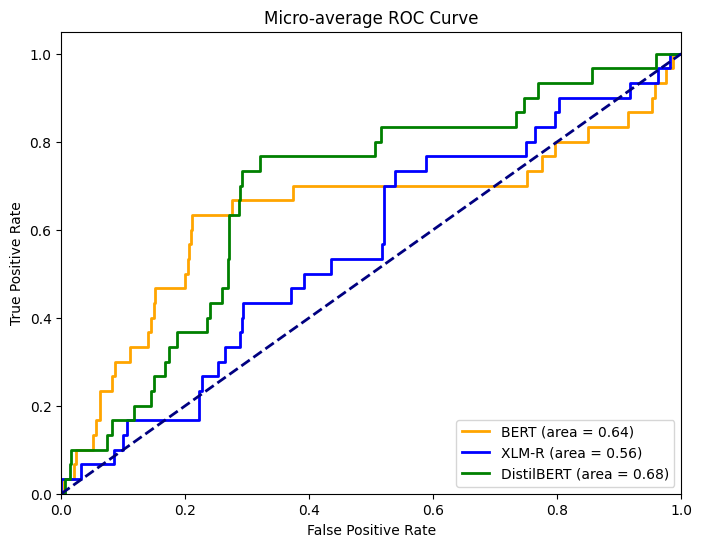

In [ ]:
# Convert labels to one-hot encoded format for BERT
one_hot_labels_bert = np.zeros((len(test_labels_bert), len(labels_dict)))
for i, label in enumerate(test_labels_bert):
    one_hot_labels_bert[i, label] = 1

# Compute probabilities for each class for BERT
probabilities_bert = np.exp(preds_bert) / np.exp(preds_bert).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for BERT
fpr_bert = dict()
tpr_bert = dict()
roc_auc_bert = dict()
for i in range(len(labels_dict)):
    fpr_bert[i], tpr_bert[i], _ = roc_curve(one_hot_labels_bert[:, i], probabilities_bert[:, i])
    roc_auc_bert[i] = auc(fpr_bert[i], tpr_bert[i])

# Compute micro-average ROC curve and AUC score for BERT
fpr_bert["micro"], tpr_bert["micro"], _ = roc_curve(one_hot_labels_bert.ravel(), probabilities_bert.ravel())
roc_auc_bert["micro"] = auc(fpr_bert["micro"], tpr_bert["micro"])

# Convert labels to one-hot encoded format for XLM-R
one_hot_labels_xlmr = np.zeros((len(test_labels_xlmr), len(labels_dict)))
for i, label in enumerate(test_labels_xlmr):
    one_hot_labels_xlmr[i, label] = 1

# Compute probabilities for each class for XLM-R
probabilities_xlmr = np.exp(preds_xlmr) / np.exp(preds_xlmr).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for XLM-R
fpr_xlmr = dict()
tpr_xlmr = dict()
roc_auc_xlmr = dict()
for i in range(len(labels_dict)):
    fpr_xlmr[i], tpr_xlmr[i], _ = roc_curve(one_hot_labels_xlmr[:, i], probabilities_xlmr[:, i])
    roc_auc_xlmr[i] = auc(fpr_xlmr[i], tpr_xlmr[i])

# Compute micro-average ROC curve and AUC score for XLM-R
fpr_xlmr["micro"], tpr_xlmr["micro"], _ = roc_curve(one_hot_labels_xlmr.ravel(), probabilities_xlmr.ravel())
roc_auc_xlmr["micro"] = auc(fpr_xlmr["micro"], tpr_xlmr["micro"])

# Convert labels to one-hot encoded format for DistilBERT
one_hot_labels_distilbert = np.zeros((len(test_labels_distilbert), len(labels_dict)))
for i, label in enumerate(test_labels_distilbert):
    one_hot_labels_distilbert[i, label] = 1

# Compute probabilities for each class for DistilBERT
probabilities_distilbert = np.exp(preds_distilbert) / np.exp(preds_distilbert).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for DistilBERT
fpr_distilbert = dict()
tpr_distilbert = dict()
roc_auc_distilbert = dict()
for i in range(len(labels_dict)):
    fpr_distilbert[i], tpr_distilbert[i], _ = roc_curve(one_hot_labels_distilbert[:, i], probabilities_distilbert[:, i])
    roc_auc_distilbert[i] = auc(fpr_distilbert[i], tpr_distilbert[i])

# Compute micro-average ROC curve and AUC score for DistilBERT
fpr_distilbert["micro"], tpr_distilbert["micro"], _ = roc_curve(one_hot_labels_distilbert.ravel(), probabilities_distilbert.ravel())
roc_auc_distilbert["micro"] = auc(fpr_distilbert["micro"], tpr_distilbert["micro"])

# Plot micro-average ROC curve for all models
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert["micro"], tpr_bert["micro"], color='orange', lw=2, label=f'BERT (area = {roc_auc_bert["micro"]:.2f})')
plt.plot(fpr_xlmr["micro"], tpr_xlmr["micro"], color='blue', lw=2, label=f'XLM-R (area = {roc_auc_xlmr["micro"]:.2f})')
plt.plot(fpr_distilbert["micro"], tpr_distilbert["micro"], color='green', lw=2, label=f'DistilBERT (area = {roc_auc_distilbert["micro"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Classification Report

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Convert predicted labels to the original label format
pred_labels_bert = np.argmax(probabilities_bert, axis=1)
pred_labels_xlmr = np.argmax(probabilities_xlmr, axis=1)
pred_labels_distilbert = np.argmax(probabilities_distilbert, axis=1)

# Compute classification report, accuracy, precision, recall, and F1 score for BERT
class_report_bert = classification_report(test_labels_bert, pred_labels_bert)
accuracy_bert = accuracy_score(test_labels_bert, pred_labels_bert)
precision_bert = precision_score(test_labels_bert, pred_labels_bert, average='weighted')
recall_bert = recall_score(test_labels_bert, pred_labels_bert, average='weighted')
f1_bert = f1_score(test_labels_bert, pred_labels_bert, average='weighted')

# Compute classification report, accuracy, precision, recall, and F1 score for XLM-R
class_report_xlmr = classification_report(test_labels_xlmr, pred_labels_xlmr)
accuracy_xlmr = accuracy_score(test_labels_xlmr, pred_labels_xlmr)
precision_xlmr = precision_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')
recall_xlmr = recall_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')
f1_xlmr = f1_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')

# Compute classification report, accuracy, precision, recall, and F1 score for DistilBERT
class_report_distilbert = classification_report(test_labels_distilbert, pred_labels_distilbert)
accuracy_distilbert = accuracy_score(test_labels_distilbert, pred_labels_distilbert)
precision_distilbert = precision_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')
recall_distilbert = recall_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')
f1_distilbert = f1_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')

# Print classification reports
print("Classification Report for BERT:")
print(class_report_bert)
print(f"Accuracy for BERT: {accuracy_bert}")
print(f"Precision for BERT: {precision_bert}")
print(f"Recall for BERT: {recall_bert}")
print(f"F1 Score for BERT: {f1_bert}")
print()

print("Classification Report for XLM-R:")
print(class_report_xlmr)
print(f"Accuracy for XLM-R: {accuracy_xlmr}")
print(f"Precision for XLM-R: {precision_xlmr}")
print(f"Recall for XLM-R: {recall_xlmr}")
print(f"F1 Score for XLM-R: {f1_xlmr}")
print()

print("Classification Report for DistilBERT:")
print(class_report_distilbert)
print(f"Accuracy for DistilBERT: {accuracy_distilbert}")
print(f"Precision for DistilBERT: {precision_distilbert}")
print(f"Recall for DistilBERT: {recall_distilbert}")
print(f"F1 Score for DistilBERT: {f1_distilbert}")


Classification Report for BERT:
              precision    recall  f1-score   support

           0       0.33      0.38      0.35         8
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         1
           6       0.10      0.67      0.17         3
           7       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         1

    accuracy                           0.17        30
   macro avg       0.04      0.10      0.05        30
weighted avg       0.10      0.17      0.11        30

Accuracy for BERT: 0.16666666666666666
Precision for BERT: 0.09841269841269841
Recall for BERT: 0.16666666666666666
F1 Score for BERT: 0.1107843137254902

Classification Report for XLM-R:
              precisi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix for BERT
conf_matrix_bert = confusion_matrix(test_labels_bert, pred_labels_bert)

# Compute confusion matrix for XLM-R
conf_matrix_xlmr = confusion_matrix(test_labels_xlmr, pred_labels_xlmr)

# Compute confusion matrix for DistilBERT
conf_matrix_distilbert = confusion_matrix(test_labels_distilbert, pred_labels_distilbert)

# Define label names based on labels dictionary
label_names = sorted(labels_dict, key=labels_dict.get)


<Figure size 800x600 with 0 Axes>

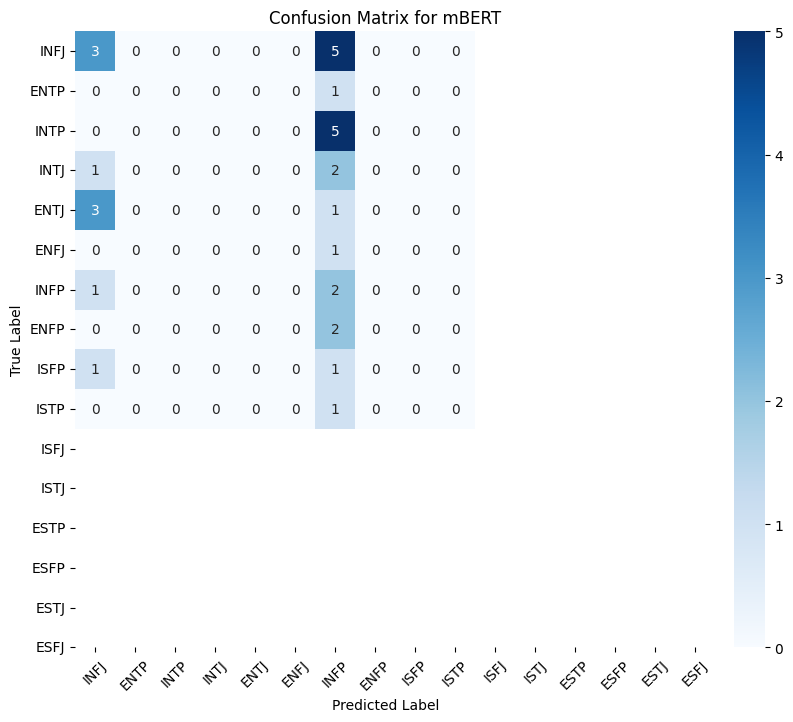

<Figure size 800x600 with 0 Axes>

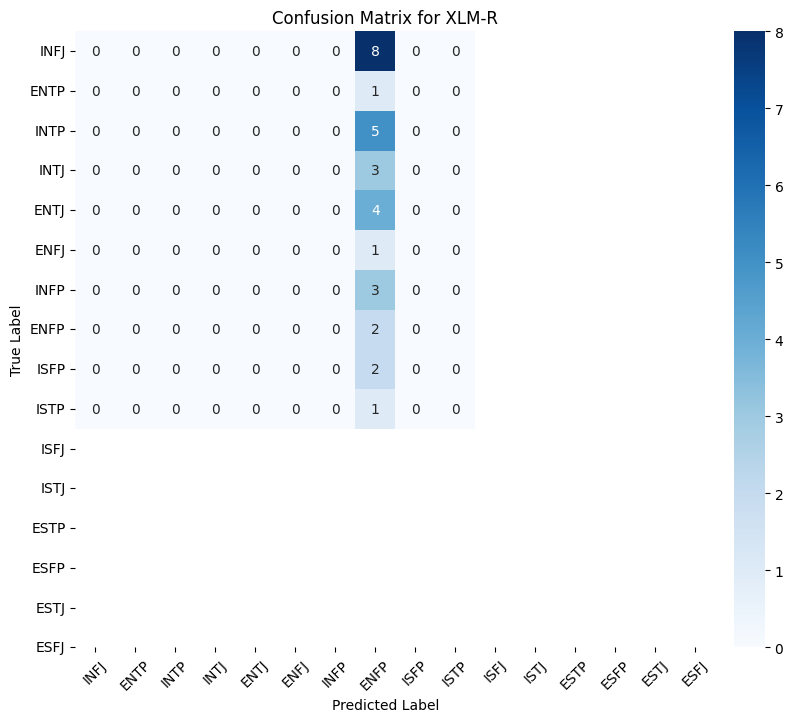

<Figure size 800x600 with 0 Axes>

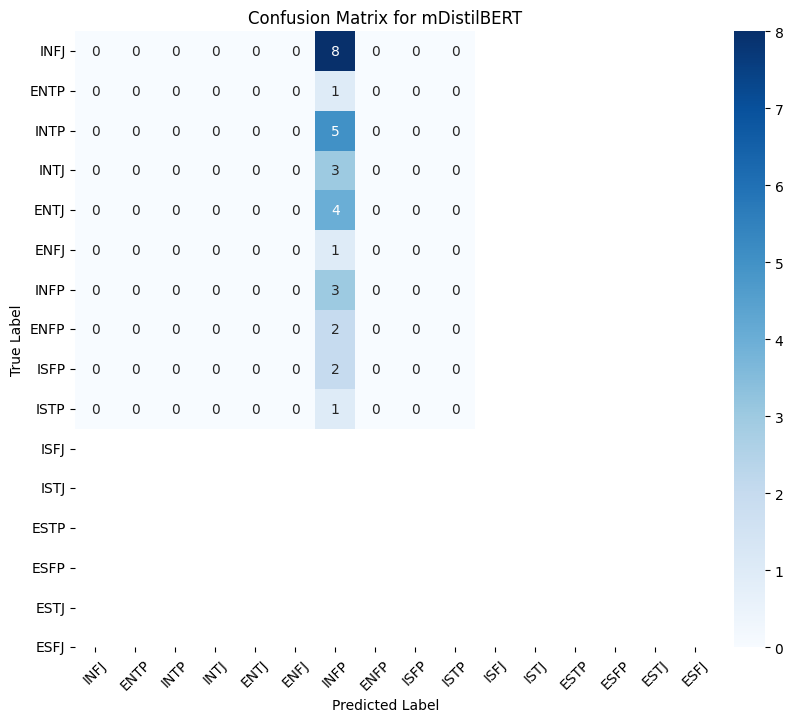

In [ ]:
import seaborn as sns

def plot_confusion_matrix(conf_matrix, label_names, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title(title)  # Set the title here
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Plot confusion matrix for BERT
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_bert, label_names, 'Confusion Matrix for mBERT')

# Plot confusion matrix for XLM-R
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_xlmr, label_names, 'Confusion Matrix for XLM-R')

# Plot confusion matrix for DistilBERT
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_distilbert, label_names, 'Confusion Matrix for mDistilBERT')

# Save the Best Performing Model

In [ ]:
import pickle

# Define the path where you want to save the model
model_save_path = '/content/gdrive/MyDrive/models/xlmr_model_5.pkl'

# Save the model using pickle
with open(model_save_path, 'wb') as f:
    pickle.dump(xlmr_model, f)


# Cyber Bullying


In [ ]:
cb = pd.read_csv('/content/gdrive/MyDrive/German_cyberbullying_utf8.csv')
cb

tweet_text cyberbullying_type  \
0      In other words #katandandre, your food was cra...  not_cyberbullying   
1      Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying   
2      @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying   
3      @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying   
4      @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying   
...                                                  ...                ...   
47687  Black ppl aren't expected to do anything, depe...          ethnicity   
47688  Turner did not withhold his disappointment. Tu...          ethnicity   
47689  I swear to God. This dumb nigger bitch. I have...          ethnicity   
47690  Yea fuck you RT @therealexel: IF YOURE A NIGGE...          ethnicity   
47691  Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...          ethnicity   

                                              Unnamed: 2  
0      Mit anderen Worten #katandandre, dein Essen wa...  
1      Warum ist #aussietv so weiß? #MKR #theblock #I...  
2      @XochitlSuckkks eine edle Hure? Oder mehr Red-...  
3      @Jason_Gio meh. :P Danke für den Hinweis, aber...  
4      @RudhoeEnglish Dies ist ein ISIS-Konto, das vo...  
...                                                  ...  
47687  Von Schwarzen wird nicht erwartet, dass sie et...  
47688  Turner verbarg seine Enttäuschung nicht. Turne...  
47689  Ich schwöre bei Gott. Diese dumme Niggerschlam...  
47690  Ja, fick dich. RT @therealexel: WENN DU EIN NI...  
47691  Bruder. Du musst dich entspannen RT @CHILLShra...  

[47692 rows x 3 columns]

In [ ]:
# Drop a column
cb.drop(columns=['tweet_text'], inplace=True)
cb.rename(columns={'Unnamed: 2': 'tweet_text'}, inplace=True)
cb

cyberbullying_type                                         tweet_text
0      not_cyberbullying  Mit anderen Worten #katandandre, dein Essen wa...
1      not_cyberbullying  Warum ist #aussietv so weiß? #MKR #theblock #I...
2      not_cyberbullying  @XochitlSuckkks eine edle Hure? Oder mehr Red-...
3      not_cyberbullying  @Jason_Gio meh. :P Danke für den Hinweis, aber...
4      not_cyberbullying  @RudhoeEnglish Dies ist ein ISIS-Konto, das vo...
...                  ...                                                ...
47687          ethnicity  Von Schwarzen wird nicht erwartet, dass sie et...
47688          ethnicity  Turner verbarg seine Enttäuschung nicht. Turne...
47689          ethnicity  Ich schwöre bei Gott. Diese dumme Niggerschlam...
47690          ethnicity  Ja, fick dich. RT @therealexel: WENN DU EIN NI...
47691          ethnicity  Bruder. Du musst dich entspannen RT @CHILLShra...

[47692 rows x 2 columns]

<Axes: xlabel='cyberbullying_type'>

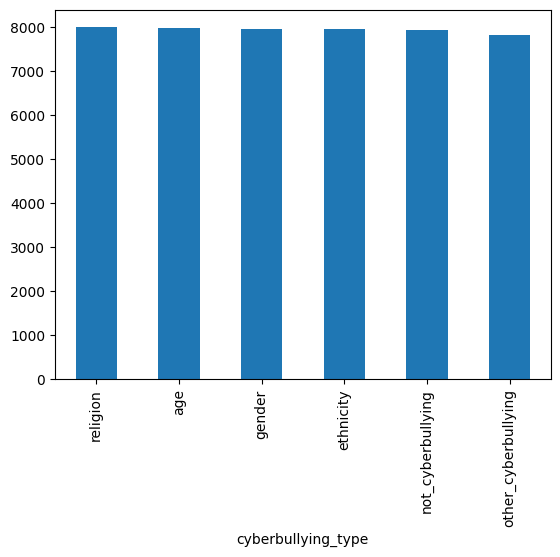

In [ ]:
cb["cyberbullying_type"].value_counts().plot(kind = "bar")

In [ ]:
# Truncate cyberbullying types to 30 characters
cb['cyberbullying_type'] = cb['cyberbullying_type'].str[:30]

In [ ]:
# Create a dictionary to store DataFrames categorized by the first 10 characters
dfs = {}

In [ ]:
# Iterate over unique categories and store filtered DataFrames
for cyberbullying_type in cb['cyberbullying_type'].unique():
    category_cb = cb[cb['cyberbullying_type'] == cyberbullying_type].drop(columns=['cyberbullying_type'])
    dfs[cyberbullying_type] = category_cb

In [ ]:
# Print the segregated DataFrames
for key, value in dfs.items():
    print(f"\nDataFrame for category '{key}':")
    # print(value)


DataFrame for category 'not_cyberbullying':

DataFrame for category 'gender':

DataFrame for category 'religion':

DataFrame for category 'other_cyberbullying':

DataFrame for category 'age':

DataFrame for category 'ethnicity':


In [ ]:
# Store the segregated DataFrames in a dictionary
segregated_cbs = {
    'not_cyberbul': cb[cb['cyberbullying_type'] == 'not_cyberbul'],
    'gender': cb[cb['cyberbullying_type'] == 'gender'],
    'religion': cb[cb['cyberbullying_type'] == 'religion'],
    'other_cyberb': cb[cb['cyberbullying_type'] == 'not_cyberbul'],
    'age': cb[cb['cyberbullying_type'] == 'age'],
    'ethnicity': cb[cb['cyberbullying_type'] == 'ethnicity']
}

In [ ]:
# Access the segregated DataFrames using their respective category names
not_cyberbul_cb = segregated_cbs['not_cyberbul']
gender_cb = segregated_cbs['gender']
religion_cb = segregated_cbs['religion']
other_cyberb_cb = segregated_cbs['other_cyberb']
age_cb = segregated_cbs['age']
ethnicity_cb = segregated_cbs['ethnicity']

In [ ]:
# Example: Accessing the 'not_cyberbul' DataFrame
print("Not Cyberbullying DataFrame:")
print(not_cyberbul_cb)

Not Cyberbullying DataFrame:
Empty DataFrame
Columns: [cyberbullying_type, tweet_text]
Index: []


In [ ]:
gender_cb

cyberbullying_type                                         tweet_text
7945              gender  Vergewaltigung ist real. Zvasiyana Nema macht ...
7946              gender  Sie haben noch nie einen Prominenten gesehen, ...
7947              gender  @ManhattaKnight Ich meine, er ist schwul, aber...
7948              gender  RT @Raul_Novoa16: @AliciaBernardez @Alex_Aim @...
7949              gender  Vergewaltigung ist Vergewaltigung. Und die Tat...
...                  ...                                                ...
15913             gender  Alle Frauen, die mich wirklich kennen, wissen,...
15914             gender  RT @_chrisdowns_: #QuestionsForMen Das ist gut...
15915             gender  Es ist scheiße, wenn einem das Lächeln aus dem...
15916             gender  Nein. Er sagte, Frauen entscheiden sich dafür,...
15917             gender  RT @uberfeminist: #TwitterFeminismus kann drei...

[7973 rows x 2 columns]

In [ ]:
import re
import nltk
import pandas as pd
import pickle
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
from collections import Counter

# Initialize Porter Stemmer
ps = PorterStemmer()

# Load the pre-trained BERT model
with open('/content/gdrive/MyDrive/models/bert_model.pkl', 'rb') as f:
    bert_model = pickle.load(f)

# Define function for tweet preprocessing
def preprocess_tweets(tweets):
    corpus = []
    for tweet in tweets:
        # Remove non-alphabetic characters and convert to lowercase
        tweet_text = re.sub("[^a-zA-Z]", " ", tweet)
        tweet_text = tweet_text.lower()

        # Tokenize the tweet
        tweet_text = tweet_text.split()

        # Remove stopwords and apply stemming
        tweet_text = [ps.stem(word) for word in tweet_text if word not in stopwords.words("german")]

        # Join the processed words back into a single string
        tweet_text = " ".join(tweet_text)

        # Append the processed tweet to the corpus
        corpus.append(tweet_text)
    return corpus

# Define function for BERT prediction
def predict_labels(tokenized_texts):
    predicted_labels = []
    for i in tqdm(range(0, len(tokenized_texts), batch_size), desc="Predicting"):
        input_batch = torch.tensor(tokenized_texts[i:i+batch_size]).to(device)
        with torch.no_grad():
            outputs = bert_model(input_batch)
            logits = outputs.logits

        # Convert logits to probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted class index for each sample in the batch
        batch_predicted_class_indices = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Convert the class indices back to their original labels
        batch_predicted_labels = [reverse_class_labels.get(idx, "Unknown") for idx in batch_predicted_class_indices]

        predicted_labels.extend(batch_predicted_labels)
    return predicted_labels

# Define function to process and predict labels for a given category DataFrame
def process_and_predict(df, category_name, reverse_class_labels):
    # Preprocess tweets
    df["tweet_text"] = df["tweet_text"].fillna("")
    corpus = preprocess_tweets(df["tweet_text"])

    # Tokenize the cleaned texts
    tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in corpus]

    # Pad sequences to ensure uniform length
    max_len = max(len(tokens) for tokens in tokenized_texts)
    padded_texts = [tokens + [0] * (max_len - len(tokens)) for tokens in tokenized_texts]

    # Predict labels
    predicted_labels = predict_labels(padded_texts, reverse_class_labels)

    # Create a new DataFrame to store the original data along with the predicted labels
    predicted_df = df.copy()
    predicted_df['predicted_labels'] = predicted_labels[:len(df)]

    # Print the unique predicted labels
    unique_labels = predicted_df['predicted_labels'].unique()
    print(f"Unique labels for '{category_name}': {unique_labels}")

    # Count the occurrences of each label
    label_counts = Counter(predicted_labels)
    for label, count in label_counts.items():
        print(f"{label}: {count} samples")

    return predicted_df

# Define function for BERT prediction
def predict_labels(tokenized_texts, reverse_class_labels):
    predicted_labels = []
    for i in tqdm(range(0, len(tokenized_texts), batch_size), desc="Predicting"):
        input_batch = torch.tensor(tokenized_texts[i:i+batch_size]).to(device)
        with torch.no_grad():
            outputs = bert_model(input_batch)
            logits = outputs.logits

        # Convert logits to probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted class index for each sample in the batch
        batch_predicted_class_indices = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Convert the class indices back to their original labels
        batch_predicted_labels = [reverse_class_labels.get(idx, "Unknown") for idx in batch_predicted_class_indices]

        predicted_labels.extend(batch_predicted_labels)
    return predicted_labels

# Define categories and respective DataFrames
categories = {
    'age': age_cb,
    'religion': religion_cb,
    'gender': gender_cb,
    'ethnicity': ethnicity_cb,
    # Add more categories as needed
}

class_labels = {
        'INFJ': 0, 'ENTP': 1, 'INTP': 2, 'INTJ': 3, 'ENTJ': 4,
        'ENFJ': 5, 'INFP': 6, 'ENFP': 7, 'ISFP': 8, 'ISTP': 9,
        'ISFJ': 10, 'ISTJ': 11, 'ESTP': 12, 'ESFP': 13,
        'ESTJ': 14, 'ESFJ': 15
    }

# Reverse the class_labels dictionary to map indices to labels
reverse_class_labels = {v: k for k, v in class_labels.items()}

# Create dictionaries to store predicted DataFrames for each category
predicted_dfs = {}

# Iterate over categories, process and predict labels
for category_name, df in categories.items():
    print(f"\nProcessing category '{category_name}':")
    predicted_df = process_and_predict(df, category_name, reverse_class_labels)
    # Store the predicted DataFrame for the category
    predicted_dfs[category_name] = predicted_df
    print(f"Predicted DataFrame for '{category_name}':\n{predicted_df.head()}")

# Print keys in the predicted_dfs dictionary
print("\nKeys in predicted_dfs dictionary:", predicted_dfs.keys())



Processing category 'age':


<ipython-input-32-178223e4e6e3>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")
Predicting: 100%|██████████| 250/250 [04:03<00:00,  1.03it/s]
<ipython-input-32-178223e4e6e3>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")


Unique labels for 'age': ['INTJ' 'ENTJ' 'ESTJ' 'ESTP']
INTJ: 4963 samples
ENTJ: 2623 samples
ESTJ: 400 samples
ESTP: 6 samples
Predicted DataFrame for 'age':
      cyberbullying_type                                         tweet_text  \
31739                age  Hier zuhause. Nachbarn schikanieren meine Fami...   
31740                age  In der Schule gemobbt werden: Leistungsstarke ...   
31741                age  In meiner sechsten Klasse gab es ein Mädchen, ...   
31742                age  Er ist wahrscheinlich ein weißer, schwuler Jun...   
31743                age  Sie werden dazu gedrängt, umzusteigen. Die Beh...   

      predicted_labels  
31739             INTJ  
31740             INTJ  
31741             INTJ  
31742             ENTJ  
31743             ESTJ  

Processing category 'religion':


Predicting:   8%|▊         | 21/250 [00:08<01:28,  2.60it/s]


KeyboardInterrupt: 

In [ ]:
# Access the predicted DataFrame for a specific category
predicted_df_age = predicted_dfs.get('age')
predicted_df_age

cyberbullying_type                                         tweet_text  \
31739                age  Hier zuhause. Nachbarn schikanieren meine Fami...   
31740                age  In der Schule gemobbt werden: Leistungsstarke ...   
31741                age  In meiner sechsten Klasse gab es ein Mädchen, ...   
31742                age  Er ist wahrscheinlich ein weißer, schwuler Jun...   
31743                age  Sie werden dazu gedrängt, umzusteigen. Die Beh...   
...                  ...                                                ...   
39726                age  Dieses Mädchen versuchte wirklich zu sagen, da...   
39727                age  ein Tyrann in der Schule, der sich seit der 3....   
39728                age  Ich erinnere mich, dass ich in der 6. Klasse e...   
39729                age  Ich war nicht die Ballkönigin. Ich war das gem...   
39730                age  Jeder versucht, ein „süßes alternatives Mädche...   

      predicted_labels  
31739             INTJ  
31740             INTJ  
31741             INTJ  
31742             ENTJ  
31743             ESTJ  
...                ...  
39726             ENTJ  
39727             INTJ  
39728             INTJ  
39729             INTJ  
39730             ENTJ  

[7992 rows x 3 columns]